In [3]:
import pandas as pd
import py7zr
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler

# Path to your .7z file
file_path = 'Data/longyear-obese-hypertensive-40-57-medical-SMALL-sample.7z'

# Open the .7z file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    all_files = z.getnames()
    # Assuming there's only one CSV file in the .7z archive
    csv_file_name = all_files[0]
    # Extract the CSV file to memory
    csv_file_dict = z.read([csv_file_name])
    csv_file = csv_file_dict[csv_file_name]

# Load the CSV data into a pandas DataFrame
df1 = pd.read_csv(csv_file)

# Now you can work with the DataFrame `df` as usual
file_path = 'Data/longyear-obese-hypertensive-40-75-scripts-SMALL-sample.7z'

# Open the .7z file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    all_files = z.getnames()
    # Assuming there's only one CSV file in the .7z archive
    csv_file_name = all_files[0]
    # Extract the CSV file to memory
    csv_file_dict = z.read([csv_file_name])
    csv_file = csv_file_dict[csv_file_name]

# Load the CSV data into a pandas DataFrame
df2 = pd.read_csv(csv_file)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df1 = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623525 entries, 0 to 623524
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         623525 non-null  object 
 1   episode_id         623525 non-null  object 
 2   visit_id           621650 non-null  object 
 3   encounter_id       623525 non-null  object 
 4   claim_date         623525 non-null  object 
 5   patient_state      623525 non-null  object 
 6   patient_short_zip  623512 non-null  float64
 7   patient_age        616980 non-null  float64
 8   patient_gender     623525 non-null  object 
 9   place_of_service   484555 non-null  object 
 10  visit_type         600454 non-null  object 
 11  payor              608936 non-null  object 
 12  payor_channel      586086 non-null  object 
 13  ref_npi            297501 non-null  float64
 14  hcp_npi            434653 non-null  float64
 15  hcp_taxonomy       428209 non-null  object 
 16  hc

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894623 entries, 0 to 894622
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   journey_id                     894623 non-null  object 
 1   cohort_id                      894623 non-null  int64  
 2   claim_id                       894623 non-null  object 
 3   patient_gender                 894623 non-null  object 
 4   patient_state                  894623 non-null  object 
 5   patient_zip                    894623 non-null  object 
 6   patient_dob                    894623 non-null  object 
 7   pharmacy_npi                   894623 non-null  object 
 8   pharmacist_npi                 894623 non-null  object 
 9   prescriber_npi                 894623 non-null  object 
 10  primary_care_npi               894623 non-null  object 
 11  group_id                       894623 non-null  object 
 12  date_of_service               

# Part 1: Exploratory Data Analysis

In [7]:
# listing all the numeric columns in the data set

numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

['patient_short_zip',
 'patient_age',
 'ref_npi',
 'hcp_npi',
 'hco_npi',
 'rev_center_code',
 'rev_center_units',
 'proc_units',
 'line_charge',
 'claim_charge',
 'smart_allowed']

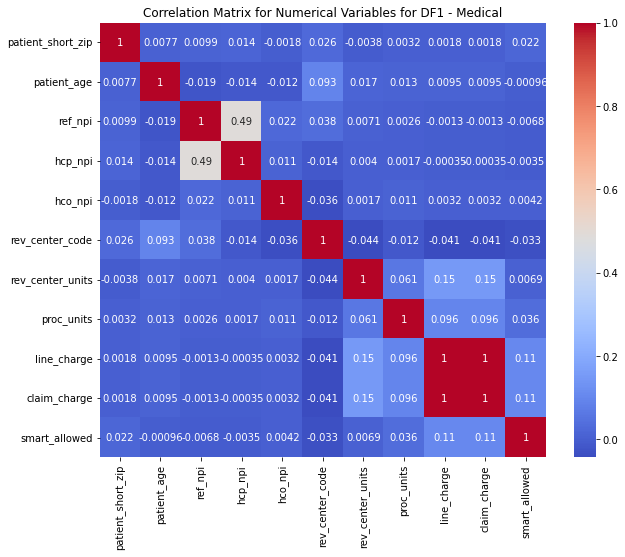

In [8]:
## Heatmap of DF1 
plt.figure(figsize=(10, 8))

correlation_matrix = df1[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Variables for DF1 - Medical')
plt.show()

1. Most of the numerical columns are not corrrelated as they are below 0.1 and -0.1 in many cases which is considered not significant.
2. A correlation of 0.49 between `hcp_npi` - the provider performing the service and `ref_npi` - the referring provider. This indicates that in some cases, the provider performing the service is moderately linked to the identity of the referring provider, may be due to referrals or networks among them.

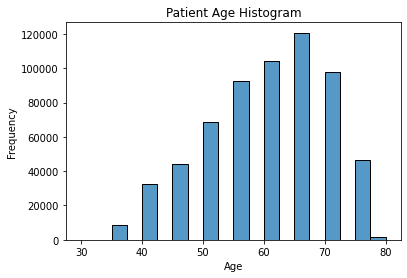

In [9]:
# EDA 1: Patient Age Frequency
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df1['patient_age'], bins=20)
plt.title('Patient Age Histogram')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


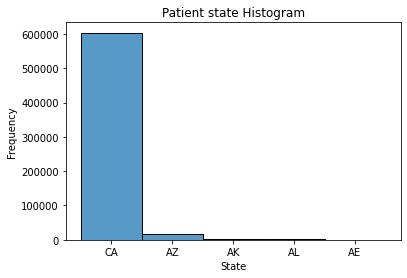

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df1['patient_state'], bins=10)
plt.title('Patient state Histogram')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.show()

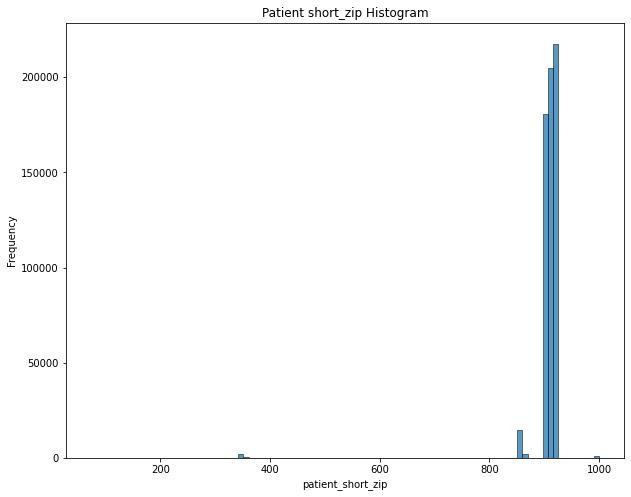

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.histplot(df1['patient_short_zip'], bins=100)
plt.title('Patient short_zip Histogram')
plt.xlabel('patient_short_zip')
plt.ylabel('Frequency')
plt.show()

In [12]:
import operator

# 1. Select 'diag_' columns
#diag_columns = [col for col in df.columns if col.startswith('diag_')]
df_zip = df1['patient_short_zip']

# 2. Combine values 
combined_list = df_zip.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# 3. Process first three digits (same as before)
zips = {}
for diag_code in combined_list:
    #first_three = diag_code[:3]
    zips[diag_code] = zips.get(diag_code, 0) + 1

sorted_counts = sorted(zips.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts:
    print(items)

(900.0, 180469)
(922.0, 166422)
(908.0, 55562)
(921.0, 51190)
(910.0, 48395)
(913.0, 34571)
(912.0, 34143)
(911.0, 32244)
(853.0, 6499)
(857.0, 2952)
(852.0, 2399)
(864.0, 1480)
(856.0, 1456)
(350.0, 1259)
(351.0, 637)
(352.0, 530)
(863.0, 495)
(859.0, 447)
(855.0, 430)
(995.0, 370)
(996.0, 359)
(860.0, 311)
(997.0, 291)
(344.0, 58)
(194.0, 42)
(850.0, 39)
(272.0, 33)
(891.0, 32)
(923.0, 25)
(304.0, 25)
(998.0, 23)
(320.0, 22)
(91.0, 22)
(629.0, 18)
(606.0, 18)
(770.0, 17)
(105.0, 15)
(787.0, 12)
(841.0, 12)
(895.0, 9)
(483.0, 9)
(333.0, 9)
(328.0, 8)
(527.0, 8)
(112.0, 8)
(370.0, 8)
(372.0, 7)
(773.0, 7)
(722.0, 7)
(170.0, 7)
(330.0, 6)
(924.0, 6)
(334.0, 6)
(528.0, 5)
(720.0, 5)
(752.0, 4)
(776.0, 4)
(524.0, 4)
(337.0, 4)
(612.0, 3)
(999.0, 3)
(88.0, 3)
(503.0, 3)
(619.0, 3)
(890.0, 3)
(933.0, 2)
(774.0, 2)
(631.0, 2)
(74.0, 2)
(478.0, 2)
(782.0, 2)
(523.0, 2)
(917.0, 2)
(554.0, 2)
(200.0, 2)
(442.0, 2)
(109.0, 1)
(481.0, 1)
(925.0, 1)
(610.0, 1)
(495.0, 1)
(321.0, 1)
(427.0, 1)
(616

Most Patients are from California.
Especially,
1. (900.0, 180469) -- Los Angeles, LA
2. (922.0, 166422) -- Riverside
3. (908.0, 55562)  -- Long Beach
4. (921.0, 51190)  -- San Diego
5. (910.0, 48395)  -- Pasific Grove
6. (913.0, 34571)  -- LA
7. (912.0, 34143)  -- Glendale, LA
8. (911.0, 32244)  -- Pasadena

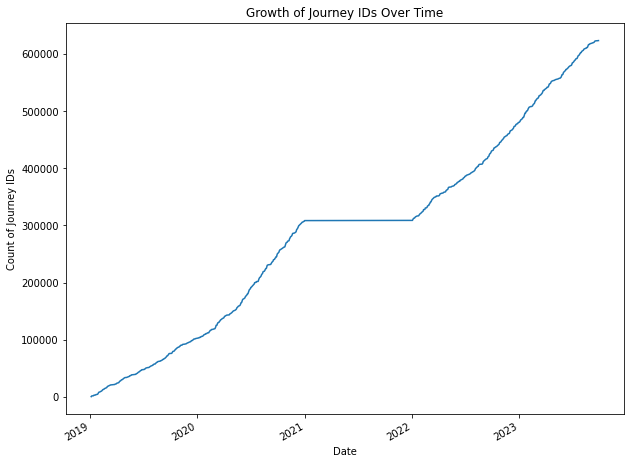

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# changing datetime format
df1['claim_date'] = pd.to_datetime(df1['claim_date'])
df1_sorted = df1.sort_values(by='claim_date')

# no of jouney id for each date
journey_ids_count = df1_sorted.groupby('claim_date').size()

# sum of new id's over time
journeys_sum = journey_ids_count.cumsum()

# Step 6: Plotting the cumulative sum over time
plt.figure(figsize=(10, 8))
journeys_sum.plot()
plt.title('Growth of Journey IDs Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Journey IDs')
plt.show()


In [14]:
#df1.diag_list

df1['diag_list'].value_counts().head(20)

Z0000        9420
I10          6535
G4733        6432
E119         5137
R6889        3720
Z1231        3510
Z20828       2082
Z7689        2074
E1165        1918
Z0189        1870
Z20822       1696
R079         1640
Z23          1614
N390         1583
Z01818       1576
I10,I10      1402
Z1211        1367
Z0001        1333
M545         1206
E119,E119    1029
Name: diag_list, dtype: int64

In [15]:
# 1. Select 'diag_' columns
diag_columns = [col for col in df1.columns if col.startswith('diag_')]
df_diag = df1[diag_columns]

# 2. Combine values 
combined_list = df_diag.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# 3. Process first three digits (same as before)
first_three_counts = {}
for diag_code in combined_list:
    first_three = diag_code[:3]
    first_three_counts[first_three] = first_three_counts.get(first_three, 0) + 1

import operator
# Sort the dictionary items by count (descending order)
sorted_counts = sorted(first_three_counts.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts:
    print(items)    

('E11', 233629)
('I10', 199537)
('E78', 113939)
('Z00', 95083)
('E66', 69689)
('Z68', 54013)
('M25', 51750)
('M54', 50447)
('Z12', 32396)
('N18', 31950)
('Z01', 30622)
('Z13', 29844)
('M79', 29497)
('G47', 28339)
('R10', 27659)
('Z79', 27149)
('E55', 27085)
('Z71', 26523)
('R07', 25175)
('E03', 24910)
('R73', 24776)
('N39', 22340)
('M17', 21592)
('D64', 19973)
('I25', 17483)
('Z20', 16871)
('R53', 16402)
('I50', 15359)
('R06', 15340)
('J44', 14592)
('F41', 13833)
('Z23', 13598)
('I48', 12605)
('K21', 12366)
('G89', 11753)
('Z11', 11720)
('I11', 11344)
('F33', 10927)
('N40', 10720)
('J45', 10699)
('E87', 10668)
('M19', 10218)
('U07', 10043)
('M47', 9806)
('R68', 9479)
('A41', 9416)
('D50', 9387)
('J96', 9330)
('R05', 9106)
('M51', 8942)
('F32', 8895)
('I12', 8183)
('L03', 7899)
('B35', 7878)
('R79', 7617)
('Z51', 7527)
('R51', 7323)
('K76', 7175)
('Z76', 7142)
('R42', 7133)
('N17', 7130)
('H25', 7047)
('L97', 7010)
('M48', 6829)
('M62', 6795)
('R00', 6751)
('F17', 6672)
('C50', 6663)
('

# Top 10 OCC

E11  Type 2 diabetes mellitus

I10  Essential (primary) hypertension

E78  Disorders of lipoprotein metabolism and other lipidemias

Z00  Encounter for general examination without complaint, suspected or reported diagnosis

E66  Overweight and obesity

In [16]:
df1['proc_code'].unique()

array(['A6549', '3074F', '3078F', ..., '88319', 'J0894', 'C1786'],
      dtype=object)

In [17]:
# OZP
filtered_df = df1[df1['proc_code'] == "J3490"]

# 1. Select 'diag_' columns
diag_columns = [col for col in filtered_df.columns if col.startswith('diag_')]
df_diag = filtered_df[diag_columns]

# 2. Combine values 
combined_list = df_diag.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# 3. Process first three digits (same as before)
first_three_counts = {}
for diag_code in combined_list:
    first_three = diag_code[:3]
    first_three_counts[first_three] = first_three_counts.get(first_three, 0) + 1

sorted_counts = sorted(first_three_counts.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts:
    print(items)

('I10', 249)
('E11', 229)
('E78', 139)
('N18', 100)
('I25', 91)
('M54', 81)
('E66', 75)
('Z79', 72)
('R07', 71)
('Z51', 64)
('I48', 56)
('J45', 50)
('G89', 49)
('M19', 46)
('M25', 44)
('R10', 44)
('D68', 40)
('F41', 37)
('Z99', 36)
('K21', 35)
('H25', 34)
('Z68', 34)
('J44', 33)
('Z30', 33)
('M17', 32)
('M47', 28)
('C50', 28)
('D50', 27)
('M79', 27)
('Z87', 26)
('Z88', 25)
('N25', 25)
('R51', 24)
('G47', 23)
('E03', 23)
('M48', 22)
('F33', 22)
('R06', 20)
('R94', 20)
('Z85', 19)
('Z20', 19)
('J20', 19)
('F17', 19)
('I50', 18)
('K29', 18)
('F32', 18)
('Z86', 17)
('M51', 17)
('I12', 17)
('R11', 16)
('M70', 16)
('N20', 16)
('I11', 16)
('K57', 15)
('K44', 15)
('K59', 15)
('C61', 15)
('Z90', 15)
('N13', 15)
('I49', 14)
('Z11', 14)
('Z01', 14)
('D63', 14)
('F31', 14)
('L02', 14)
('G43', 12)
('K80', 12)
('M16', 12)
('D64', 12)
('R05', 12)
('J30', 12)
('R26', 12)
('H40', 12)
('K43', 12)
('R19', 12)
('N39', 12)
('K40', 12)
('R52', 12)
('Z95', 11)
('C77', 11)
('D25', 11)
('N95', 11)
('T85', 11)


# TOP 5 OCC for OZP Users
I10  Essential (primary) hypertension

E11  Type 2 diabetes mellitus

E78  Disorders of lipoprotein metabolism and other lipidemias

N18  Chronic kidney disease (CKD)

I25  Chronic ischemic heart disease


In [18]:
df1_obesity = df1[df1['diag_1'].str.startswith("E66")|
      df1['diag_2'].str.startswith("E66")|
      df1['diag_3'].str.startswith("E66")|
      df1['diag_4'].str.startswith("E66")|
      df1['diag_5'].str.startswith("E66")]


df1_obesity['diag'] = "Obesity"
df1_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63026 entries, 22 to 623506
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   journey_id         63026 non-null  object        
 1   episode_id         63026 non-null  object        
 2   visit_id           62900 non-null  object        
 3   encounter_id       63026 non-null  object        
 4   claim_date         63026 non-null  datetime64[ns]
 5   patient_state      63026 non-null  object        
 6   patient_short_zip  63018 non-null  float64       
 7   patient_age        62224 non-null  float64       
 8   patient_gender     63026 non-null  object        
 9   place_of_service   50211 non-null  object        
 10  visit_type         59858 non-null  object        
 11  payor              60251 non-null  object        
 12  payor_channel      58314 non-null  object        
 13  ref_npi            24221 non-null  float64       
 14  hcp_

/var/folders/81/0csrmw5941v1ks_klqtm9ny40000gn/T/ipykernel_85401/93696038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_obesity['diag'] = "Obesity"


In [19]:
patients_gender_cnt = df1_obesity.groupby(['diag', 'patient_gender'])['journey_id'].nunique().reset_index(name = 'count')
total_cnt = patients_gender_cnt.groupby('diag')['count'].transform('sum')
patients_gender_cnt['gender_ratio'] = patients_gender_cnt['count']/total_cnt
patients_gender_cnt

,diag,patient_gender,count,gender_ratio
0,Obesity,F,6422,0.587127
1,Obesity,M,4514,0.412690
2,Obesity,None,2,0.000183


# Part 2

In [20]:
print(df1.isnull().sum())

journey_id                0
episode_id                0
visit_id               1875
encounter_id              0
claim_date                0
patient_state             0
patient_short_zip        13
patient_age            6545
patient_gender            0
place_of_service     138970
visit_type            23071
payor                 14589
payor_channel         37439
ref_npi              326024
hcp_npi              188872
hcp_taxonomy         195316
hcp_specialty        195296
hco_npi                5736
hcp_npi_list         188872
hco_npi_list           5736
diag_list               870
diag_1                  870
diag_2               162930
diag_3               258241
diag_4               325292
diag_5               418509
rev_center_code      509599
rev_center_units       1967
proc_code             23913
proc_modifier        457577
proc_units             2194
line_charge               0
claim_charge              0
smart_allowed             0
dtype: int64


In [21]:
print(df2.isnull().sum())

journey_id                            0
cohort_id                             0
claim_id                              0
patient_gender                        0
patient_state                         0
patient_zip                           0
patient_dob                           0
pharmacy_npi                          0
pharmacist_npi                        0
prescriber_npi                        0
primary_care_npi                      0
group_id                              0
date_of_service                       0
date_authorized                       0
transaction_type                      0
date_prescription_written             0
ndc11                                 0
ndc11_original                        0
number_of_refills_authorized      45104
diagnosis_code                    80548
diagnosis_code_type                   0
quantity_prescribed_original     572275
quantity_dispensed                    7
place_of_service                      0
is_service                            0


In [22]:
# Join both df
df = pd.merge(df1, df2, on='journey_id', how='inner')

In [23]:
## handleing the duplicated columns

for column in set(df.columns):
    if column.endswith('_x'):
        col_y = column[:-2] + '_y'
        if col_y in df.columns: 
            df[column] = df[column].combine_first(df[col_y])
            df.drop(col_y, axis=1, inplace=True)  

df.columns = [col[:-2] if col.endswith('_x') else col for col in df.columns]


In [24]:
df2['copay_coinsurance']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
894618    NaN
894619    NaN
894620    NaN
894621    NaN
894622    NaN
Name: copay_coinsurance, Length: 894623, dtype: float64

In [25]:
columns_of_interest = ['journey_id', 'claim_date', 'patient_state', 'patient_age', 'patient_gender', 'diag_list', 'diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5', \
                        'proc_code', 'proc_modifier', 'proc_units', 'smart_allowed', 'number_of_refills_authorized', 'quantity_prescribed_original', 'quantity_dispensed', \
                            'place_of_service', 'is_service', 'level_of_service', 'fill_number', 'days_supply', 'pharmacy_submitted_cost', 'is_compound_drug', 'start_date', 'end_date']

df = df[columns_of_interest].drop_duplicates()

In [26]:
df['ozp'] = 0

lst_ozp = df[df['proc_code'] == "J3490"]['journey_id'].unique()
df.loc[df['journey_id'].isin(lst_ozp), 'ozp'] = 1

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16177269 entries, 0 to 29731050
Data columns (total 28 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   journey_id                    object        
 1   claim_date                    datetime64[ns]
 2   patient_state                 object        
 3   patient_age                   float64       
 4   patient_gender                object        
 5   diag_list                     object        
 6   diag_1                        object        
 7   diag_2                        object        
 8   diag_3                        object        
 9   diag_4                        object        
 10  diag_5                        object        
 11  proc_code                     object        
 12  proc_modifier                 object        
 13  proc_units                    float64       
 14  smart_allowed                 float64       
 15  number_of_refills_authorized  

In [27]:
counts = df['ozp'].value_counts()
print(counts)

0    14978291
1     1198978
Name: ozp, dtype: int64


In [28]:
lst_obesity = df[df['diag_1'].str.startswith("E66")|
      df['diag_2'].str.startswith("E66")|
      df['diag_3'].str.startswith("E66")|
      df['diag_4'].str.startswith("E66")|
      df['diag_5'].str.startswith("E66")]['journey_id']

In [29]:
df_obesity = df[df['journey_id'].isin(lst_obesity)]
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10044924 entries, 112 to 29730566
Data columns (total 28 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   journey_id                    object        
 1   claim_date                    datetime64[ns]
 2   patient_state                 object        
 3   patient_age                   float64       
 4   patient_gender                object        
 5   diag_list                     object        
 6   diag_1                        object        
 7   diag_2                        object        
 8   diag_3                        object        
 9   diag_4                        object        
 10  diag_5                        object        
 11  proc_code                     object        
 12  proc_modifier                 object        
 13  proc_units                    float64       
 14  smart_allowed                 float64       
 15  number_of_refills_authorized

In [30]:
df_obesity['obesity'] = 0

df_obesity.loc[df_obesity['diag_1'].str.startswith("E66") |
               df_obesity['diag_2'].str.startswith("E66") |
               df_obesity['diag_3'].str.startswith("E66") |
               df_obesity['diag_4'].str.startswith("E66") |
               df_obesity['diag_5'].str.startswith("E66"), 'obesity'] = 1



/var/folders/81/0csrmw5941v1ks_klqtm9ny40000gn/T/ipykernel_85401/3414330989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesity['obesity'] = 0
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [31]:
filtered_obesity_df = df_obesity.groupby('journey_id').filter(lambda x: x['claim_date'].nunique() > 1)

df_obesity_sorted = filtered_obesity_df.sort_values(by=['journey_id', 'claim_date'])


# Filter the DataFrame to include only rows where 'proc_code' == "J3490" and 'opz' == 1
filtered_df_ozp = df_obesity_sorted[(df_obesity_sorted['proc_code'] == "J3490") & (df_obesity_sorted['ozp'] == 1)]
filtered_df_no_ozp = df_obesity_sorted[df_obesity_sorted['ozp'] == 0]

filtered_df = pd.concat([filtered_df_ozp, filtered_df_no_ozp]).reset_index(drop=True)

# Group by 'journey_id' and get the first record for each group
first_obesity_records = filtered_df.groupby('journey_id').head(1).copy()
first_obesity_records = first_obesity_records[first_obesity_records['obesity']==1]


## The last record of the patient
last_obesity_records = df_obesity_sorted.groupby('journey_id').tail(1).copy()

In [32]:
result_obesity_records = last_obesity_records[['journey_id', 'claim_date', 'smart_allowed', 'obesity']]
result_obesity_records = result_obesity_records.rename(columns={'claim_date': 'end_claim_date', 'smart_allowed': 'end_smart_allowed', 'obesity': 'end_obesity'})

In [34]:
df_obesity_first_last = pd.merge(first_obesity_records, result_obesity_records, on='journey_id', how='inner')

df_obesity_full = df_obesity_first_last
df_obesity_full['claim_total_days'] = (df_obesity_full['end_claim_date'] - df_obesity_full['claim_date']).dt.days
df_obesity_full['cured'] = df_obesity_full['obesity'] - df_obesity_full['end_obesity']

df_obesity_full = df_obesity_full.drop(['diag_list', 'diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5', 'quantity_prescribed_original', 'obesity', 'end_obesity', 'end_date', 'start_date',  'claim_date', 'end_claim_date'], axis=1)

In [35]:
lst_hypertensive = df[df['diag_1'].str.startswith("I10")|
      df['diag_2'].str.startswith("I10")|
      df['diag_3'].str.startswith("I10")|
      df['diag_4'].str.startswith("I10")|
      df['diag_5'].str.startswith("I10")]['journey_id']

In [36]:
df_hypertensive = df[df['journey_id'].isin(lst_hypertensive)]
df_hypertensive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14276948 entries, 246 to 29730566
Data columns (total 28 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   journey_id                    object        
 1   claim_date                    datetime64[ns]
 2   patient_state                 object        
 3   patient_age                   float64       
 4   patient_gender                object        
 5   diag_list                     object        
 6   diag_1                        object        
 7   diag_2                        object        
 8   diag_3                        object        
 9   diag_4                        object        
 10  diag_5                        object        
 11  proc_code                     object        
 12  proc_modifier                 object        
 13  proc_units                    float64       
 14  smart_allowed                 float64       
 15  number_of_refills_authorized

In [37]:
df_hypertensive['hypertensive'] = 0

df_hypertensive.loc[df_hypertensive['diag_1'].str.startswith("I10", na=False) |
                    df_hypertensive['diag_2'].str.startswith("I10", na=False) |
                    df_hypertensive['diag_3'].str.startswith("I10", na=False) |
                    df_hypertensive['diag_4'].str.startswith("I10", na=False) |
                    df_hypertensive['diag_5'].str.startswith("I10", na=False), 'hypertensive'] = 1

/var/folders/81/0csrmw5941v1ks_klqtm9ny40000gn/T/ipykernel_85401/3031254774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hypertensive['hypertensive'] = 0
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [38]:
filtered_hypertensive_df = df_hypertensive.groupby('journey_id').filter(lambda x: x['claim_date'].nunique() > 1)

df_hypertensive_sorted = filtered_hypertensive_df.sort_values(by=['journey_id', 'claim_date'])


# Filter the DataFrame to include only rows where 'proc_code' == "J3490" and 'opz' == 1
filtered_df_ozp = df_hypertensive_sorted[(df_hypertensive_sorted['proc_code'] == "J3490") & (df_hypertensive_sorted['ozp'] == 1)]
filtered_df_no_ozp = df_hypertensive_sorted[df_hypertensive_sorted['ozp'] == 0]

filtered_df = pd.concat([filtered_df_ozp, filtered_df_no_ozp]).reset_index(drop=True)

# Group by 'journey_id' and get the first record for each group
first_hypertensive_records = filtered_df.groupby('journey_id').head(1).copy()
first_hypertensive_records = first_hypertensive_records[first_hypertensive_records['hypertensive']==1]


## The last record of the patient
last_hypertensive_records = df_hypertensive_sorted.groupby('journey_id').tail(1).copy()

In [39]:
result_hypertensive_records = last_hypertensive_records[['journey_id', 'claim_date', 'smart_allowed', 'hypertensive']]
result_hypertensive_records = result_hypertensive_records.rename(columns={'claim_date': 'end_cliam_date', 'smart_allowed': 'end_smart_allowed', 'hypertensive': 'end_hypertensive'})

In [40]:
df_hypertensive_first_last = pd.merge(first_hypertensive_records, result_hypertensive_records, on='journey_id', how='inner')

df_hypertensive_full = df_hypertensive_first_last
df_hypertensive_full['claim_total_days'] = (df_hypertensive_full['end_cliam_date'] - df_hypertensive_full['claim_date']).dt.days
df_hypertensive_full['cured'] = df_hypertensive_full['hypertensive'] - df_hypertensive_full['end_hypertensive']

df_hypertensive_full = df_hypertensive_full.drop(['diag_list', 'diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5', 'quantity_prescribed_original', 'hypertensive', 'end_hypertensive', 'end_date', 'start_date',  'claim_date', 'end_cliam_date'], axis=1)

In [41]:
df_hypertensive_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 0 to 3119
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   journey_id                    3120 non-null   object 
 1   patient_state                 3120 non-null   object 
 2   patient_age                   3101 non-null   float64
 3   patient_gender                3120 non-null   object 
 4   proc_code                     3065 non-null   object 
 5   proc_modifier                 491 non-null    object 
 6   proc_units                    3103 non-null   float64
 7   smart_allowed                 3120 non-null   float64
 8   number_of_refills_authorized  2963 non-null   float64
 9   quantity_dispensed            3120 non-null   float64
 10  place_of_service              3120 non-null   object 
 11  is_service                    3120 non-null   object 
 12  level_of_service              3120 non-null   object 
 13  fil

In [42]:
df_obesity_full['proc_code'].fillna(value='empty', inplace=True)

df_obesity_full['proc_modifier'].fillna(value='empty', inplace=True)

mode_age = df_obesity_full['patient_age'].mode()[0]
df_obesity_full['patient_age'].fillna(value=mode_age, inplace=True)

mode_proc_units = df_obesity_full['proc_units'].mode()[0]
df_obesity_full['proc_units'].fillna(value=mode_proc_units, inplace=True)

mode_number_of_refills_authorized = df_obesity_full['number_of_refills_authorized'].mode()[0]
df_obesity_full['number_of_refills_authorized'].fillna(value=mode_number_of_refills_authorized, inplace=True)

mode_pharmacy_submitted_cost = df_obesity_full['pharmacy_submitted_cost'].mode()[0]
df_obesity_full['pharmacy_submitted_cost'].fillna(value=mode_pharmacy_submitted_cost, inplace=True)

df_obesity_full.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1175
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   journey_id                    1176 non-null   object 
 1   patient_state                 1176 non-null   object 
 2   patient_age                   1176 non-null   float64
 3   patient_gender                1176 non-null   object 
 4   proc_code                     1176 non-null   object 
 5   proc_modifier                 1176 non-null   object 
 6   proc_units                    1176 non-null   float64
 7   smart_allowed                 1176 non-null   float64
 8   number_of_refills_authorized  1176 non-null   float64
 9   quantity_dispensed            1176 non-null   float64
 10  place_of_service              1176 non-null   object 
 11  is_service                    1176 non-null   object 
 12  level_of_service              1176 non-null   object 
 13  fil

In [43]:
df_hypertensive_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 0 to 3119
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   journey_id                    3120 non-null   object 
 1   patient_state                 3120 non-null   object 
 2   patient_age                   3101 non-null   float64
 3   patient_gender                3120 non-null   object 
 4   proc_code                     3065 non-null   object 
 5   proc_modifier                 491 non-null    object 
 6   proc_units                    3103 non-null   float64
 7   smart_allowed                 3120 non-null   float64
 8   number_of_refills_authorized  2963 non-null   float64
 9   quantity_dispensed            3120 non-null   float64
 10  place_of_service              3120 non-null   object 
 11  is_service                    3120 non-null   object 
 12  level_of_service              3120 non-null   object 
 13  fil

In [44]:
df_hypertensive_full['proc_code'].fillna(value='empty', inplace=True)

df_hypertensive_full['proc_modifier'].fillna(value='empty', inplace=True)

mode_age = df_hypertensive_full['patient_age'].mode()[0]
df_hypertensive_full['patient_age'].fillna(value=mode_age, inplace=True)

mode_proc_units = df_hypertensive_full['proc_units'].mode()[0]
df_hypertensive_full['proc_units'].fillna(value=mode_proc_units, inplace=True)

mode_number_of_refills_authorized = df_hypertensive_full['number_of_refills_authorized'].mode()[0]
df_hypertensive_full['number_of_refills_authorized'].fillna(value=mode_number_of_refills_authorized, inplace=True)

mode_pharmacy_submitted_cost = df_hypertensive_full['pharmacy_submitted_cost'].mode()[0]
df_hypertensive_full['pharmacy_submitted_cost'].fillna(value=mode_pharmacy_submitted_cost, inplace=True)

df_hypertensive_full.info()

df_hypertensive_full = df_hypertensive_full.drop(['journey_id'], axis=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 0 to 3119
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   journey_id                    3120 non-null   object 
 1   patient_state                 3120 non-null   object 
 2   patient_age                   3120 non-null   float64
 3   patient_gender                3120 non-null   object 
 4   proc_code                     3120 non-null   object 
 5   proc_modifier                 3120 non-null   object 
 6   proc_units                    3120 non-null   float64
 7   smart_allowed                 3120 non-null   float64
 8   number_of_refills_authorized  3120 non-null   float64
 9   quantity_dispensed            3120 non-null   float64
 10  place_of_service              3120 non-null   object 
 11  is_service                    3120 non-null   object 
 12  level_of_service              3120 non-null   object 
 13  fil

## Part 3



In [45]:
import numpy as np

class SelectiveRegularizationLinearRegression:
    def __init__(self, alpha, apply_penalty, tolerance=1e-4, max_iterations=1000):
        self.alpha = alpha
        self.tolerance = tolerance
        self.apply_penalty = apply_penalty
        self.max_iterations = max_iterations
        self.w = None
        
    def _predicted_values(self, X, w):
        return np.matmul(X, w)

    def _rho_compute(self, y, X, w, j):
        X_k = np.delete(X, j, 1)
        w_k = np.delete(w, j)
        predict_k = self._predicted_values(X_k, w_k)
        residual = y - predict_k
        rho_j = np.sum(X[:, j] * residual)
        return rho_j

    def _z_compute(self, X):
        return np.sum(X * X, axis=0)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        if not self.w:
            self.w = np.zeros(n_features)
        z = self._z_compute(X)
        for iteration in range(self.max_iterations):
            max_step = 0
            for j in range(n_features):
                rho_j = self._rho_compute(y, X, self.w, j)
                w_j_old = self.w[j]
                if j == 0:
                    self.w[j] = rho_j / z[j]
                else:
                    if self.apply_penalty[j]:
                        if rho_j < -self.alpha * n_samples:
                            self.w[j] = (rho_j + self.alpha * n_samples) / z[j]
                        elif -self.alpha * n_samples <= rho_j <= self.alpha * n_samples:
                            self.w[j] = 0.
                        elif rho_j > self.alpha * n_samples:
                            self.w[j] = (rho_j - self.alpha * n_samples) / z[j]
                    else:
                        self.w[j] = rho_j / z[j]
                max_step = max(max_step, abs(self.w[j] - w_j_old))
            if max_step < self.tolerance:
                break
        return self

    def predict(self, X):
        if self.w is None:
            raise ValueError("Model is not fitted yet!")
        return self._predicted_values(X, self.w)

In [50]:
from sklearn.preprocessing import LabelEncoder

## Stage 1
# Encoded data
df_obesity_encoded = pd.DataFrame()

# Label Encoding for each column
for column in df_obesity_full.columns:
    le = LabelEncoder()
    df_obesity_encoded[column] = le.fit_transform(df_obesity_full[column])

X = df_obesity_encoded.drop(['cured', 'ozp'], axis=1).values

#  ADD INTERCEPT
n_samples = len(X)
X = np.hstack((np.ones((n_samples, 1)), X))
d = df_obesity_encoded['ozp'].values

In [56]:
df_obesity_full.columns

Index(['journey_id', 'patient_state', 'patient_age', 'patient_gender',
       'proc_code', 'proc_modifier', 'proc_units', 'smart_allowed',
       'number_of_refills_authorized', 'quantity_dispensed',
       'place_of_service', 'is_service', 'level_of_service', 'fill_number',
       'days_supply', 'pharmacy_submitted_cost', 'is_compound_drug', 'ozp',
       'end_smart_allowed', 'claim_total_days', 'cured'],
      dtype='object')

In [57]:



apply_penalty = [True]*len(X)

alpha = 0.1 # L1 penalty term
max_iterations = 1000 # Optional, determines how long the model will look for an l1 penalty
model_1 = SelectiveRegularizationLinearRegression(alpha, apply_penalty, max_iterations)
model_1.fit(X, d)

# identify features with influence


features = ['intercept'] + ['patient_state', 'patient_age', 'patient_gender',
       'proc_code', 'proc_modifier', 'proc_units', 'smart_allowed',
       'number_of_refills_authorized', 'quantity_dispensed',
       'place_of_service', 'is_service', 'level_of_service', 'fill_number',
       'days_supply', 'pharmacy_submitted_cost', 'is_compound_drug', 'ozp',
       'end_smart_allowed', 'claim_total_days']

# Variables selected after Lasso
print("Features with Strong Influence on Obesity:")

d_lst = []
for i, coef in enumerate(model_1.w):
    if abs(coef) > 0:
        print(f"{features[i]}: {coef}")
        d_lst.append(features[i])

# Preparing the outcome variable
y = df_obesity_encoded['cured'].values




Features with Strong Influence on Obesity:
intercept: 0.026360544217687076
proc_modifier: 0.00018374099758042565
proc_units: -0.0005218441510250429
number_of_refills_authorized: 9.882525945974865e-05
place_of_service: -0.00032258061548598276
is_service: -0.000275298791542822
is_compound_drug: -1.966195431368159e-05
end_smart_allowed: 3.7188373412355795e-05
claim_total_days: -2.678052193749262e-05


In [58]:
# Including only the selected features from Stage 1 plus the treatment variable
X_stage2 = df_obesity_encoded[d_lst[1:] + ['ozp']].values
X_stage2_columns = df_obesity_encoded[d_lst[1:] + ['ozp']].columns


# Add an intercept to the features matrix for Stage 2
X_stage2 = np.hstack((np.ones((n_samples, 1)), X_stage2))

# Initialize the model without regularization on the treatment variable
apply_penalty_stage2 = [False] + [True] * (len(d_lst))  # No penalty on the intercept and treatment variable

# Instantiate the model for Stage 2
model_2 = SelectiveRegularizationLinearRegression(alpha, apply_penalty_stage2, max_iterations=max_iterations)

# Fit the model for Stage 2
model_2.fit(X_stage2, y)

# Display the coefficients for the variables including the treatment effect
print("Coefficients for Outcome Prediction:")
for i, coef in enumerate(model_2.w):
    if i == 0:
        print(f"Intercept: {coef}")
    else:
        # Adjusting index for treatment variable inclusion
        print(f"{d_lst[i] if i < len(d_lst) else 'ozp'}: {coef}")

import statsmodels.api as sm
from sklearn.metrics import accuracy_score


# Calculate predictions
y_pred = model_2.predict(X_stage2)

# Evaluate predictive performance
mse = np.mean((y - y_pred)**2)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared value
r_squared = 1 - (np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2))
print(f"R-squared: {r_squared}")

# Assuming y is the true labels and y_pred are the predictions made by the model
accuracy = accuracy_score(y, (y_pred > 0.5).astype(int))  # Using 0.5 as a threshold for
print(f"Accuracy: {accuracy:.2f}")

Coefficients for Outcome Prediction:
Intercept: 0.746867104219479
proc_modifier: 0.0
proc_units: 0.0
number_of_refills_authorized: 0.0
place_of_service: 0.0
is_service: 0.0
is_compound_drug: 0.0
end_smart_allowed: 0.0001410347676256603
claim_total_days: 7.804954415380421e-05
ozp: 0.0
Mean Squared Error: 0.15807024506926842
R-squared: 0.005059392929529949
Accuracy: 0.80
